In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader('TSLA', 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999
2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000
2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999
2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001
2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001


In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window = 100).mean()
mavg.tail()

Date
2017-01-05    202.0822
2017-01-06    202.1164
2017-01-09    202.1931
2017-01-10    202.2594
2017-01-11    202.3216
Name: Adj Close, dtype: float64

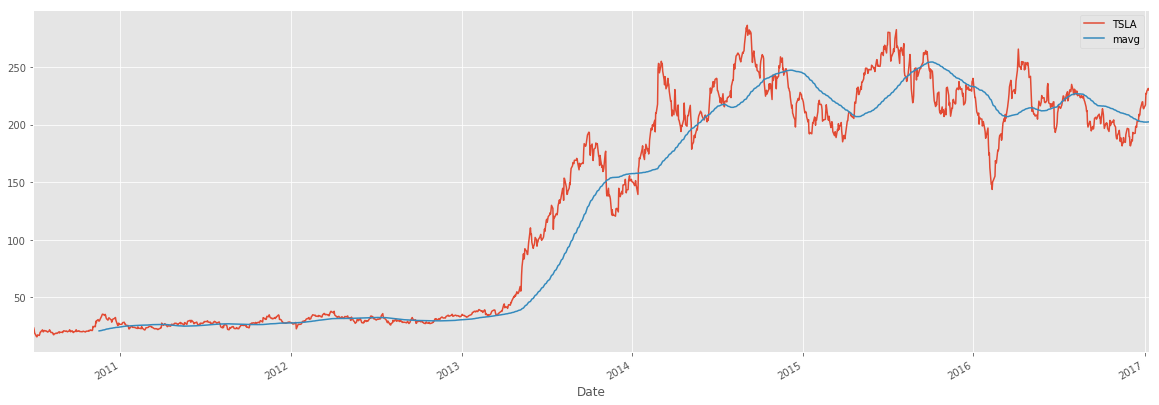

In [5]:
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size
import matplotlib as mpl
mpl.rc('figure', figsize = (20, 7))
mpl.__version__

# Adjusting a style of matplotlib
style.use('ggplot')

close_px.plot(label = 'TSLA')
mavg.plot(label = 'mavg')
# Showing labels
plt.legend()

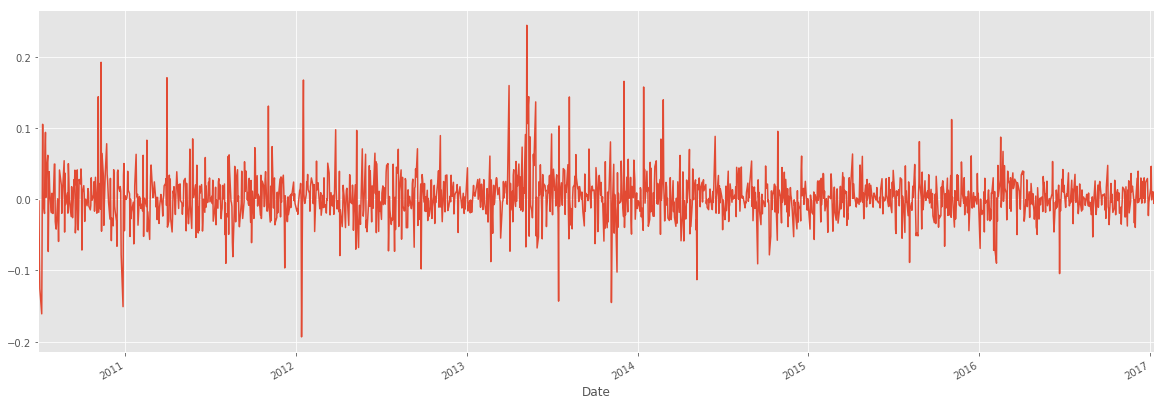

In [6]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label = 'return')

In [7]:
dfcomp = web.DataReader(['TSLA', 'AAPL', 'GE', 'IBM'], 'yahoo', start = start, end = end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,IBM,TSLA
Date,,,,
2017-01-05,111.727715,27.911093,150.013260,226.750000
2017-01-06,112.973305,27.990791,150.751312,229.009995
2017-01-09,114.008080,27.857965,149.079559,231.279999
2017-01-10,114.123047,27.778269,147.185501,229.869995
2017-01-11,114.736275,27.866817,149.168472,229.729996


In [8]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr.tail()

Symbols,AAPL,GE,IBM,TSLA
Symbols,,,,
AAPL,1.000000,0.381450,0.383840,0.218394
GE,0.381450,1.000000,0.535167,0.244641
IBM,0.383840,0.535167,1.000000,0.233574
TSLA,0.218394,0.244641,0.233574,1.000000


Text(0, 0.5, 'Returns GE')

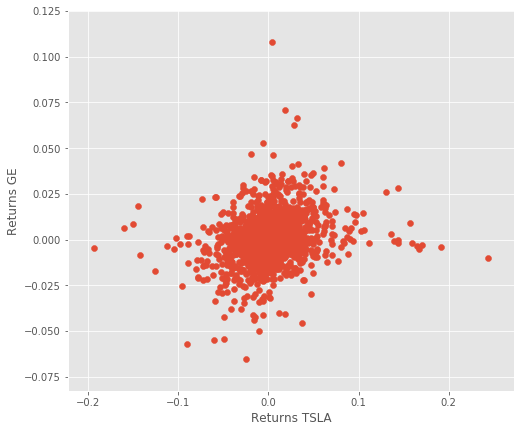

In [9]:
mpl.rc('figure', figsize = (8, 7))
plt.scatter(retscomp.TSLA, retscomp.GE)
plt.xlabel('Returns TSLA')
plt.ylabel('Returns GE')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a92387358>,
      dtype=object)

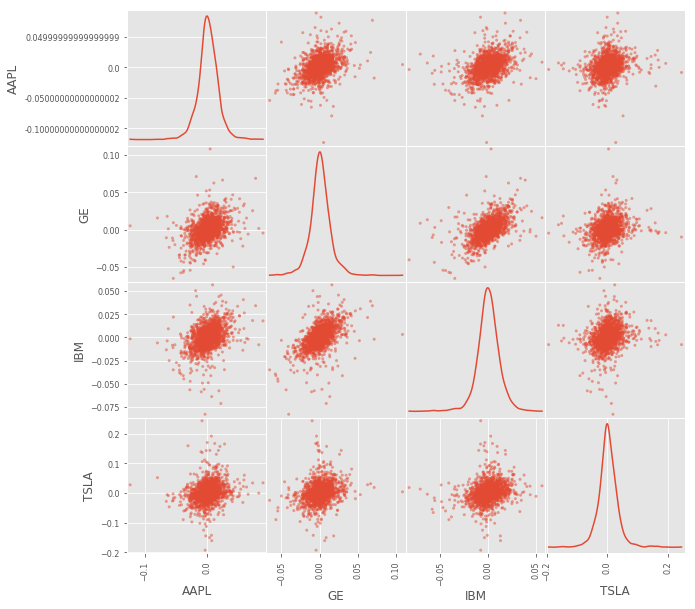

In [10]:
pd.plotting.scatter_matrix(retscomp, diagonal = 'kde', figsize = (10,10))

([<matplotlib.axis.YTick at 0x7f7a89b23898>,
 <a list of 4 Text yticklabel objects>)

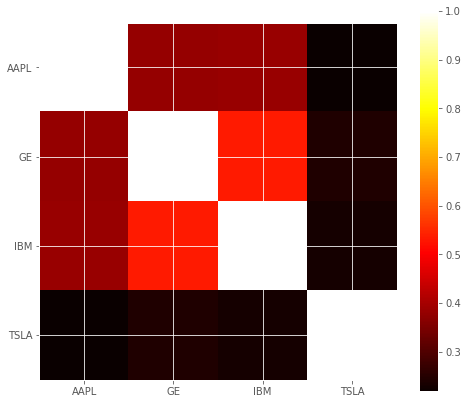

In [11]:
plt.imshow(corr, cmap = 'hot', interpolation = 'none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

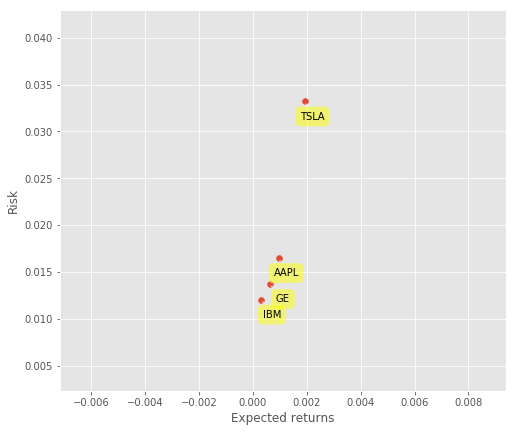

In [12]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [29]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [26]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [47]:
print('Score:', confidencereg)

Score: 0.9681069031492451


In [45]:
print('Score:', confidencepoly2)

Score: 0.9723889125213134


In [46]:
print('Score:', confidenceknn)

Score: 0.9503470071772238


In [0]:
forecast_set_reg = clfreg.predict(X_lately)
forecast_set_poly2 = clfpoly2.predict(X_lately)
forecast_set_knn = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

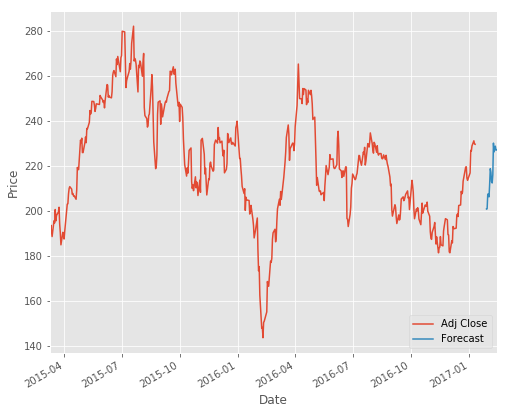

In [37]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

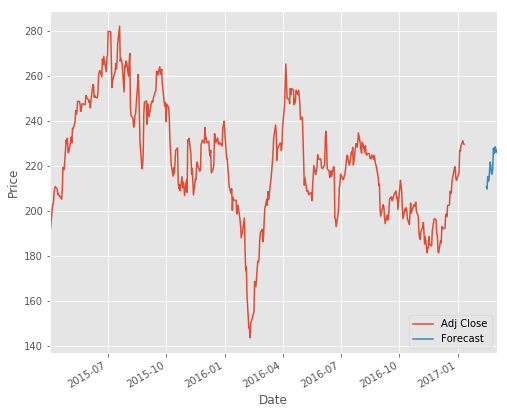

In [39]:
for i in forecast_set_poly2:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

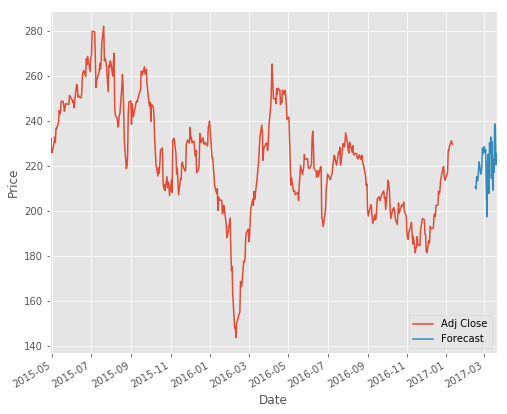

In [40]:
for i in forecast_set_knn:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()